In [2]:
import random
import pydicom
import cv2

import numpy as np
from scipy import ndimage

from skimage import io
from skimage.feature import canny
from skimage.filters import gabor_kernel
from skimage import measure

from matplotlib import pyplot as plt, animation

import os
import time

In [3]:
path = './RM_Brain_3D-SPGR/' #agafem la ruta a la carpeta train
files_names = os.listdir(path) #obtenim els noms dels arxius que hi ha dins la carpeta train
#files_names

In [4]:
files_names[3]

'000003.dcm'

## – cargar imagenes DICOM mediante instrucciones de codigo

In [5]:
dcms = pydicom.dcmread(path + files_names[0])

In [6]:
tag = dcms.SliceLocation
tag

'90.0592346191'

In [7]:
print("Slice location...:", dcms.get('SliceLocation'))
#(0020, 1041) Slice Location                      DS: '-86.9407653809'

Slice location...: 90.0592346191


Ordenam les slices:

In [8]:
llista = []

for i in range(len(files_names)):
    dcms = pydicom.dcmread(path + files_names[i])
    dcm_rest = dcms
    img_rest = dcm_rest.pixel_array
    
    loc = dcms.SliceLocation
    llista.append( (loc, img_rest) )
    
llista.sort() ### LLISTA ORDENADA

In [9]:
TENSOR_BRAIN = np.stack([slice for _, slice in llista])
TENSOR_BRAIN = np.flip(TENSOR_BRAIN, 0)


In [10]:
pixel_len_mm = [1, 0.5078, 0.5078]

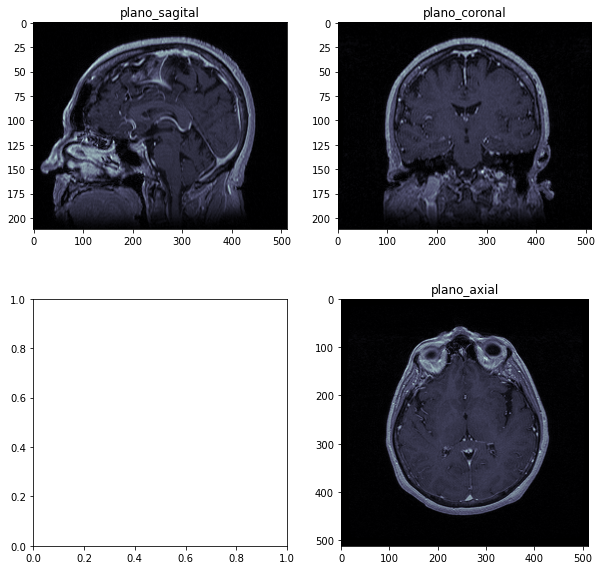

In [11]:
plano_medio_sagital = TENSOR_BRAIN[:, :, TENSOR_BRAIN.shape[2]//2]
plano_medio_coronal = TENSOR_BRAIN[:, TENSOR_BRAIN.shape[1]//2, :]
plano_medio_axial = TENSOR_BRAIN[TENSOR_BRAIN.shape[0]//2, :, :]
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs[0,0].imshow(plano_medio_sagital, cmap=plt.cm.get_cmap('bone'), aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[0,1].imshow(plano_medio_coronal, cmap=plt.cm.get_cmap('bone'), aspect=pixel_len_mm[0]/pixel_len_mm[2])
axs[1,1].imshow(plano_medio_axial, cmap=plt.cm.get_cmap('bone'))

axs[0,0].set_title("plano_sagital")
axs[0,1].set_title("plano_coronal")
axs[1,1].set_title("plano_axial");

#VISUALITZACIÓ PER CAPES VISTA AXIAL
brain_img = TENSOR_BRAIN[0, :, :]
test = 0*np.ones((brain_img.shape[0],brain_img.shape[1],3),dtype=np.uint8)
for i in range (len(files_names)):
    brain_img = TENSOR_BRAIN[i, :, :]
    
    test = 0*np.ones((brain_img.shape[0],brain_img.shape[1],3),dtype=np.uint8)
    for i in range(3):
        test[:,:,i] = brain_img
        
    cv2.imshow('Vista Cervell', test)
    cv2.waitKey(150)
cv2.destroyAllWindows()

### Carreguem els altres tensors, els phantom i l'atlas:

In [12]:
dcms2 = pydicom.dcmread('icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm')
dcms3 = pydicom.dcmread('icbm_avg_152_t1_tal_nlin_symmetric_VI_alternative.dcm')
dcms4 = pydicom.dcmread('AAL3_1mm.dcm')

In [13]:
dcm_rest = dcms2
TENSOR_PHANTOM = dcm_rest.pixel_array
TENSOR_PHANTOM = np.flip(TENSOR_PHANTOM, 0)
TENSOR_PHANTOM = np.flip(TENSOR_PHANTOM, 1)

In [14]:
TENSOR_PHANTOM[0].shape

(229, 193)

In [15]:
plano_medio_sagital_phantom = TENSOR_PHANTOM[:, :, TENSOR_PHANTOM.shape[2]//2]
plano_medio_coronal_phantom = TENSOR_PHANTOM[:, TENSOR_PHANTOM.shape[1]//2, :]
plano_medio_axial_phantom = TENSOR_PHANTOM[TENSOR_PHANTOM.shape[0]//2, :, :]

# Visualitzador síncron

In [16]:
def visualiz_sincrono(TENSOR_A, TENSOR_B, PAINTED = False, POINT = (0, 0, 0)):
    
    sagital_A = TENSOR_A[:, :, TENSOR_A.shape[2]//2]
    coronal_A = TENSOR_A[:, TENSOR_A.shape[1]//2, :]
    axial_A = TENSOR_A[TENSOR_A.shape[0]//2, :, :]

    sagital_B = TENSOR_B[:, :, TENSOR_B.shape[2]//2]
    coronal_B = TENSOR_B[:, TENSOR_B.shape[1]//2, :]
    axial_B = TENSOR_B[TENSOR_B.shape[0]//2, :, :]
    
    #---------------------------------------------------------------------------------------------------------------------------------------------------------------

    if (PAINTED == True):
        
        sagital_paint_A = sagital_A.copy()
        coronal_paint_A = coronal_A.copy()
        axial_paint_A = axial_A.copy()

        sagital_paint_B = sagital_B.copy()
        coronal_paint_B = coronal_B.copy()
        axial_paint_B = axial_B.copy()

        sagital_paint_A = cv2.line(sagital_paint_A, (point[0], 0), (point[0], sagital_A.shape[1]), (255,0,0), 1)
        sagital_paint_A = cv2.line(sagital_paint_A, (0, point[2]), (sagital_A.shape[1], point[2]), (255,0,0), 1)  

        coronal_paint_A = cv2.line(coronal_paint_A, (point[1], 0), (point[1], coronal_A.shape[1]), (255,0,0), 1)
        coronal_paint_A = cv2.line(coronal_paint_A, (0, point[2]), (coronal_A.shape[1], point[2]), (255,0,0), 1)

        axial_paint_A = cv2.line(axial_paint_A, (point[1], 0), (point[1], axial_A.shape[1]), (255,0,0), 1)
        axial_paint_A = cv2.line(axial_paint_A, (0, point[0]), (axial_A.shape[1], point[0]), (255,0,0), 1)

        sagital_paint_B = cv2.line(sagital_paint_B, (point[0], 0), (point[0], sagital_B.shape[1]), (255,0,0), 1)
        sagital_paint_B = cv2.line(sagital_paint_B, (0, point[2]), (sagital_B.shape[1], point[2]), (255,0,0), 1)  

        coronal_paint_B = cv2.line(coronal_paint_B, (point[1], 0), (point[1], coronal_B.shape[1]), (255,0,0), 1)
        coronal_paint_B = cv2.line(coronal_paint_B, (0, point[2]), (coronal_B.shape[1], point[2]), (255,0,0), 1)

        axial_paint_B = cv2.line(axial_paint_B, (point[1], 0), (point[1], axial_A.shape[1]), (255,0,0), 1)
        axial_paint_B = cv2.line(axial_paint_B, (0, point[0]), (axial_A.shape[1], point[0]), (255,0,0), 1)

    #---------------------------------------------------------------------------------------------------------------------------------------------------------------

    if (PAINTED == False):
        fig, axs = plt.subplots(2,4, figsize=(30,20))
        axs[0,0].imshow(sagital_A)
        axs[0,1].imshow(coronal_A)
        axs[1,1].imshow(axial_A)

        #cambiar les seguents imatges per les corresponents de l'atlas
        axs[0,2].imshow(sagital_B)
        axs[0,3].imshow(coronal_B)
        axs[1,3].imshow(axial_B)

        axs[0,0].set_title("plano_sagital")
        axs[0,1].set_title("plano_coronal")
        axs[1,1].set_title("plano_axial");

        axs[0,2].set_title("plano_sagital")
        axs[0,3].set_title("plano_coronal")
        axs[1,3].set_title("plano_axial");
    
    if (PAINTED == True):
        fig, axs = plt.subplots(2,4, figsize=(30,20))
        axs[0,0].imshow(sagital_paint_A)
        axs[0,1].imshow(coronal_paint_A)
        axs[1,1].imshow(axial_paint_A)

        #cambiar les seguents imatges per les corresponents de l'atlas
        axs[0,2].imshow(sagital_paint_B)
        axs[0,3].imshow(coronal_paint_B)
        axs[1,3].imshow(axial_paint_B)

        axs[0,0].set_title("plano_sagital")
        axs[0,1].set_title("plano_coronal")
        axs[1,1].set_title("plano_axial");

        axs[0,2].set_title("plano_sagital")
        axs[0,3].set_title("plano_coronal")
        axs[1,3].set_title("plano_axial");

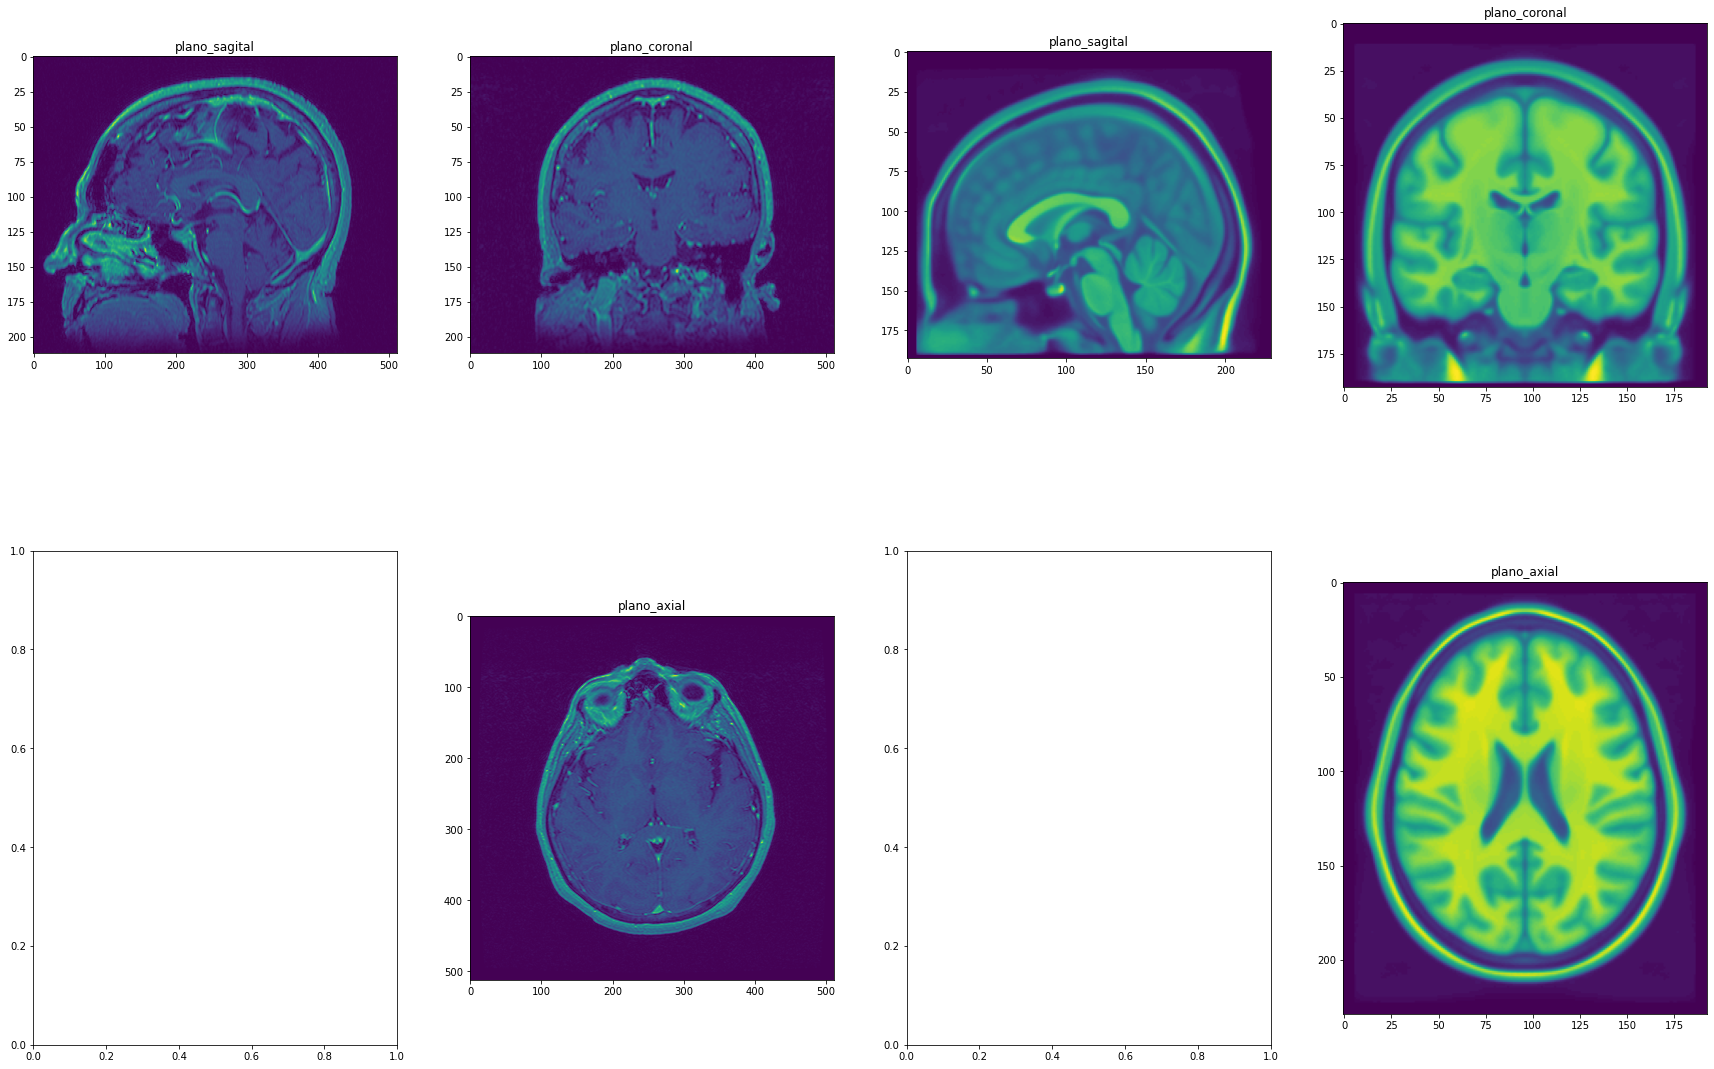

In [17]:
fig, axs = plt.subplots(2,4, figsize=(30,20))
axs[0,0].imshow(plano_medio_sagital, aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[0,1].imshow(plano_medio_coronal, aspect=pixel_len_mm[0]/pixel_len_mm[2])
axs[1,1].imshow(plano_medio_axial)

#cambiar les seguents imatges per les corresponents de l'atlas
axs[0,2].imshow(plano_medio_sagital_phantom)
axs[0,3].imshow(plano_medio_coronal_phantom)
axs[1,3].imshow(plano_medio_axial_phantom)

axs[0,0].set_title("plano_sagital")
axs[0,1].set_title("plano_coronal")
axs[1,1].set_title("plano_axial");

axs[0,2].set_title("plano_sagital")
axs[0,3].set_title("plano_coronal")
axs[1,3].set_title("plano_axial");

## Notar que les imatges tenen tamanys diferents, hem de modificar l'escalat de la imatge del pacient anonimitzat.

# Corregistre

In [18]:
from scipy.ndimage import zoom

### En primer lloc, modifiquem el tamany dels voxels de la imatge del pacient per a que correspongui amb el del phantom

In [19]:
#pixel_len_mm = [1, 0.5078, 0.5078]
BRAIN_RESHAPE = zoom(TENSOR_BRAIN, pixel_len_mm)

### Ja ho tenim reescalat:

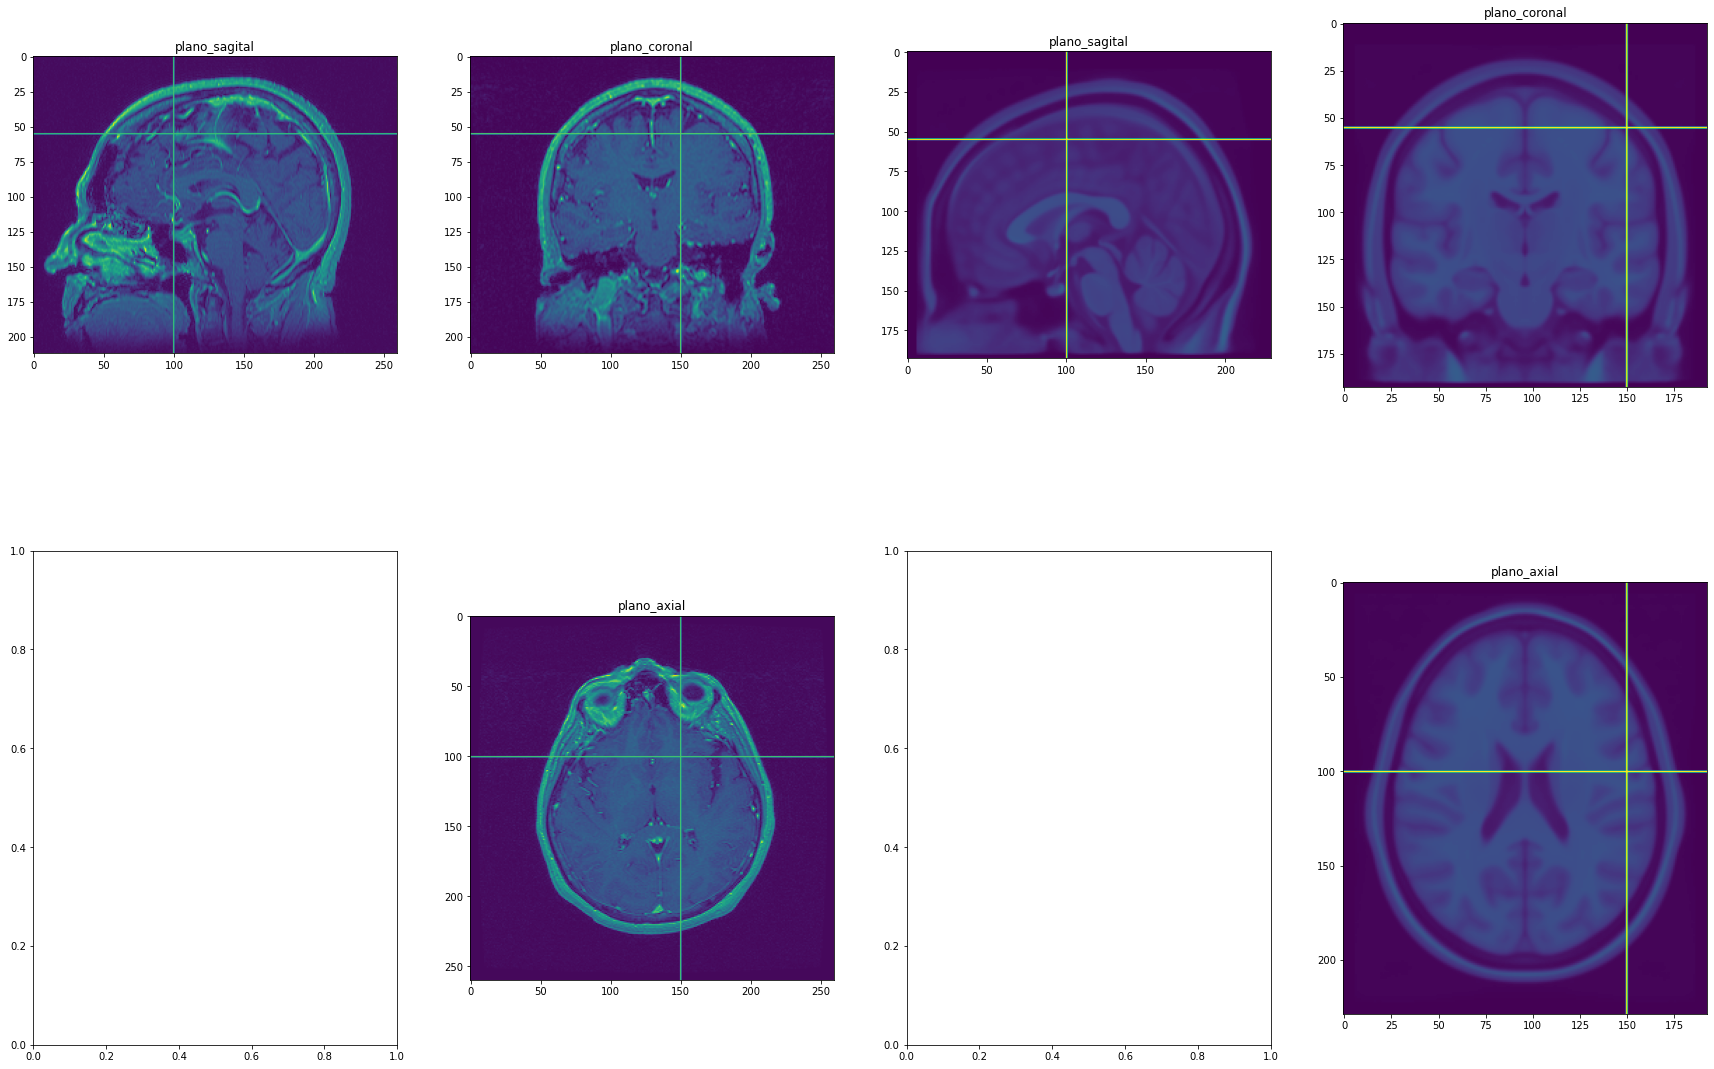

In [20]:
point = (100, 150, 55)
visualiz_sincrono(BRAIN_RESHAPE, TENSOR_PHANTOM, True, point)

#### Es pot veure com les dimensions no corresponen, falta redimensionar el contingut de la imatge, per a solventar-ho, tallarem la imàtge del nostre pacient a la mateixa mida del phantom

In [21]:
#tallem la imatge
BRAIN_CUTTED = BRAIN_RESHAPE[10:203,20:249,35:228]

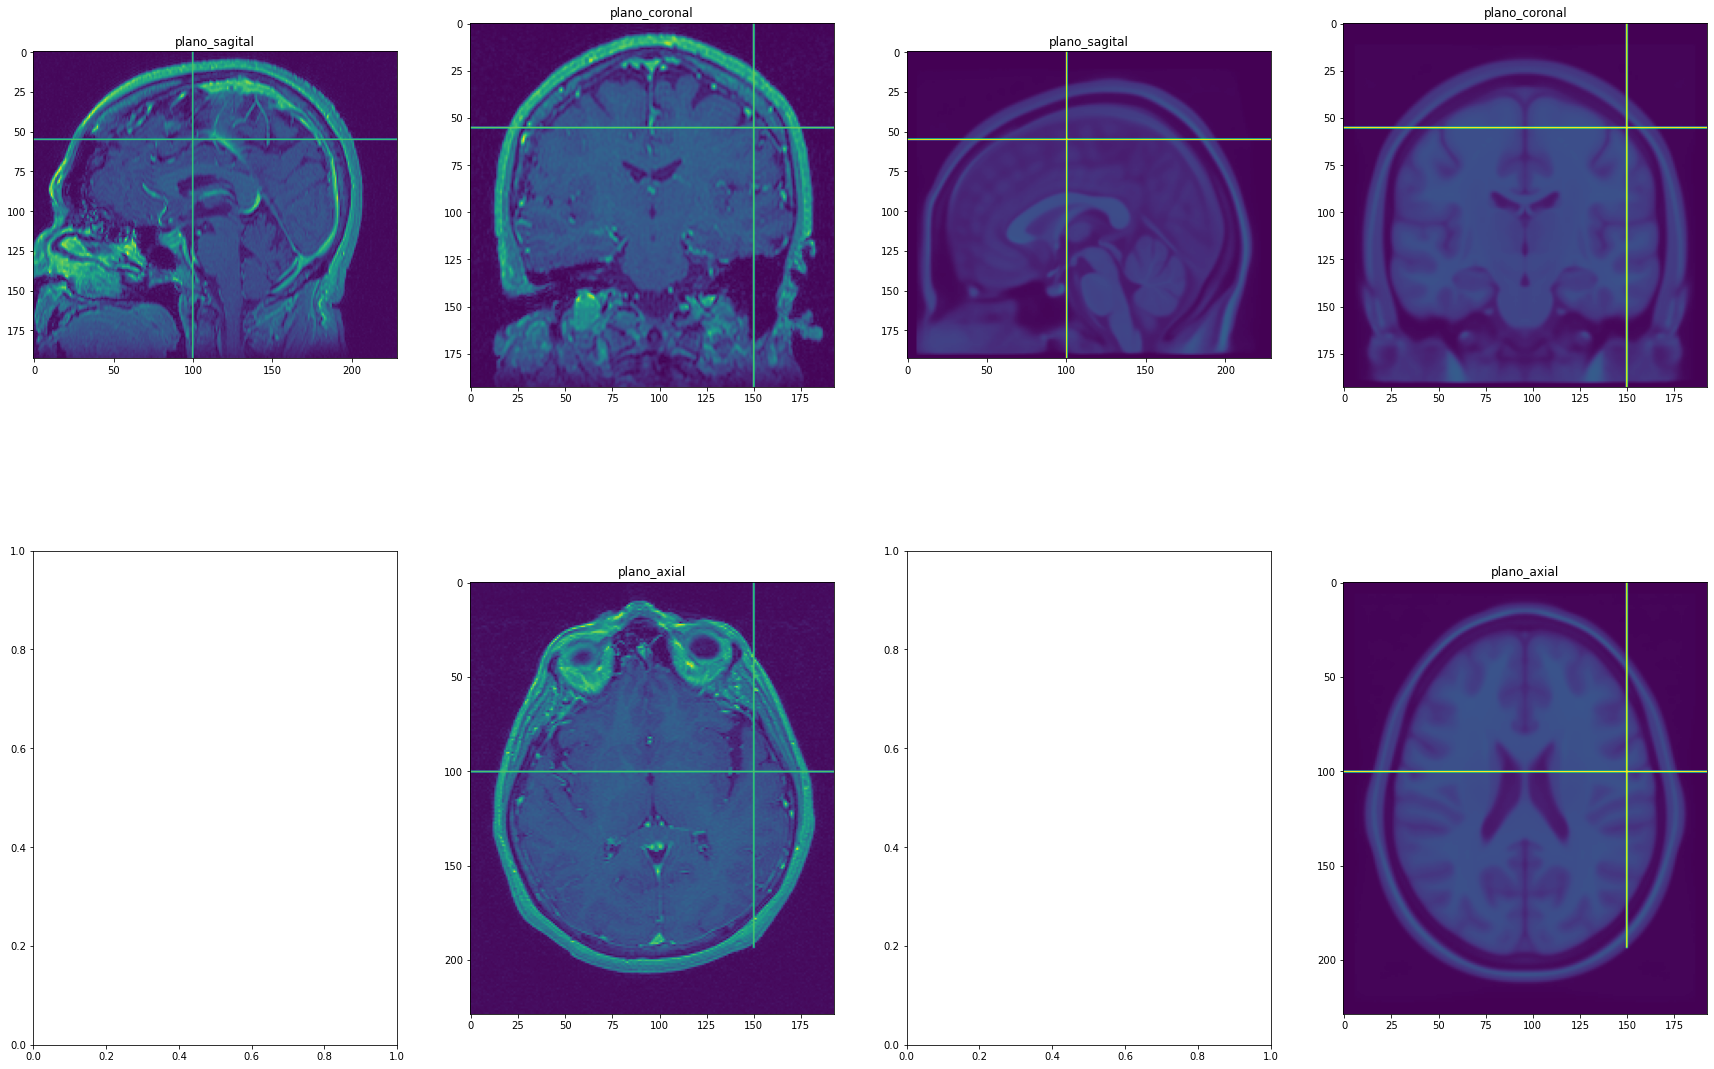

In [22]:
point = (100, 150, 55)
visualiz_sincrono(BRAIN_CUTTED, TENSOR_PHANTOM , True, point)

## Es pot veure com ara les dimensions estàn molt més ajustades, pero tot i així, encara falta ajustarho més. A continuació aplicarem el corregistre.

In [23]:
from scipy import ndimage, misc

In [24]:
TENSOR_TEST = BRAIN_CUTTED
TENSOR_TEST.shape, TENSOR_PHANTOM.shape

((193, 229, 193), (193, 229, 193))

In [25]:
def TRASLATE_TENSOR(TENSOR, vector):
    shifted = ndimage.shift(TENSOR, (vector[0], vector[1], vector[2]))
    return shifted
    

In [26]:
def ROTATE_TENSOR(TENSOR, ROT_VECTOR):

    TENSOR = ndimage.interpolation.rotate(TENSOR, ROT_VECTOR[0], (0,1),reshape=False)

    TENSOR = ndimage.interpolation.rotate(TENSOR, ROT_VECTOR[1], (0,2),reshape=False)

    TENSOR = ndimage.interpolation.rotate(TENSOR, ROT_VECTOR[2], (1,2),reshape=False)
    
    return TENSOR

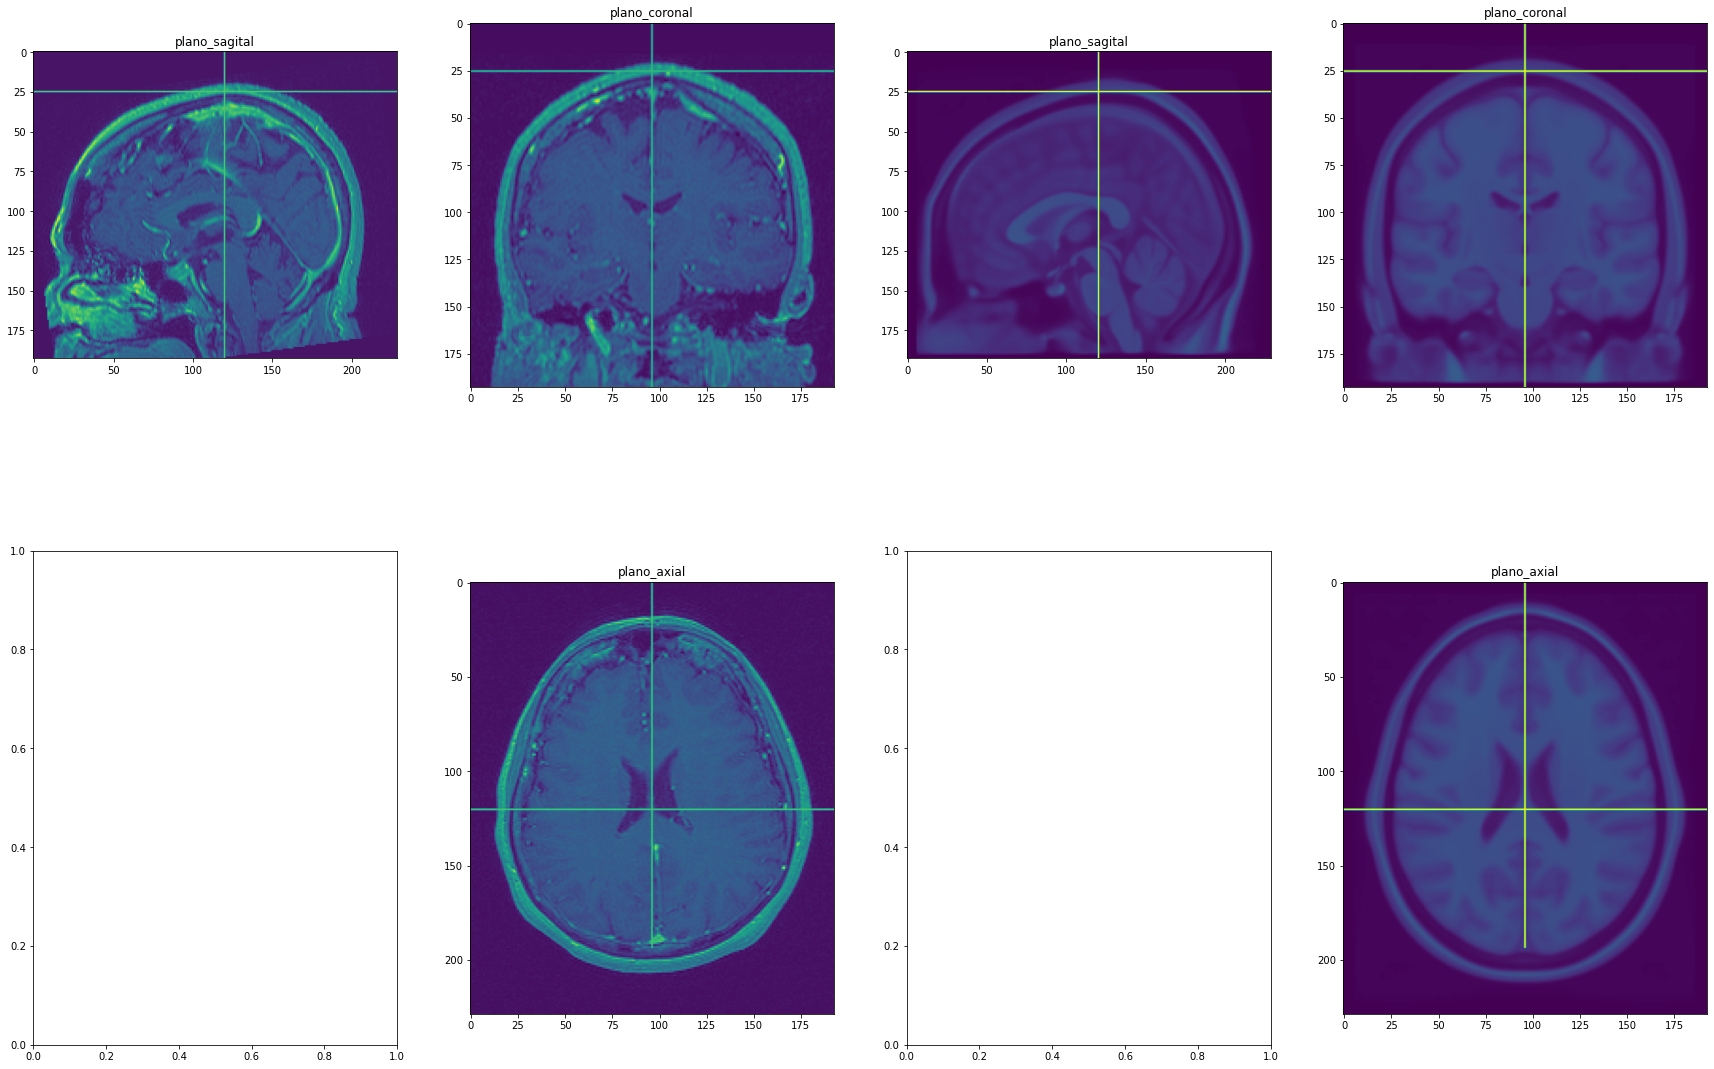

In [27]:
t_vector = (17, -1, 0) #t_vector = (18, -7, 0)
r_vector = (8, 0 ,0) #r_vector = (15, 0 ,0)

TENSOR_TL = TRASLATE_TENSOR(TENSOR_TEST, t_vector)
TENSOR_FINAL = ROTATE_TENSOR(TENSOR_TL, r_vector)

point = (120, 96, 25) #punt referencia: (65, 96, 115)  (120, 96, 25) 
visualiz_sincrono(TENSOR_FINAL, TENSOR_PHANTOM, True, point)

### Es pot veure com, amb els cursors desplegats, una vegada rotat i traslladat el tensor, les dimensions quadren de manera correcta

 # Representació de l'hipotàlam.

### A continuacó aplicarem l'algorisme del pintor, juntament amb la funsió de pèrdua, per tal de comprobar com de ben ajustades estàn les imatges

In [28]:
def F_PERDUA(TENSOR_1, TENSOR_2):
    TENSOR_A = TENSOR_1.astype(np.float64)
    TENSOR_B = TENSOR_2.astype(np.float64)
    absresult = cv2.absdiff(TENSOR_1, TENSOR_2)
    suma = 0
    suma_2 = 0
    suma_3 = 0
    for valor in absresult:
        suma = suma + valor

    for valor in suma:
        suma_2 = suma_2 + valor

    for valor in suma_2:
        suma_3 = suma_3 + valor

    return suma_3  

### Com el tensor s'ha mogut, modificarem els talls que observem al visualitzador síncron per tal de poder ajustar l'slice que es mostra.

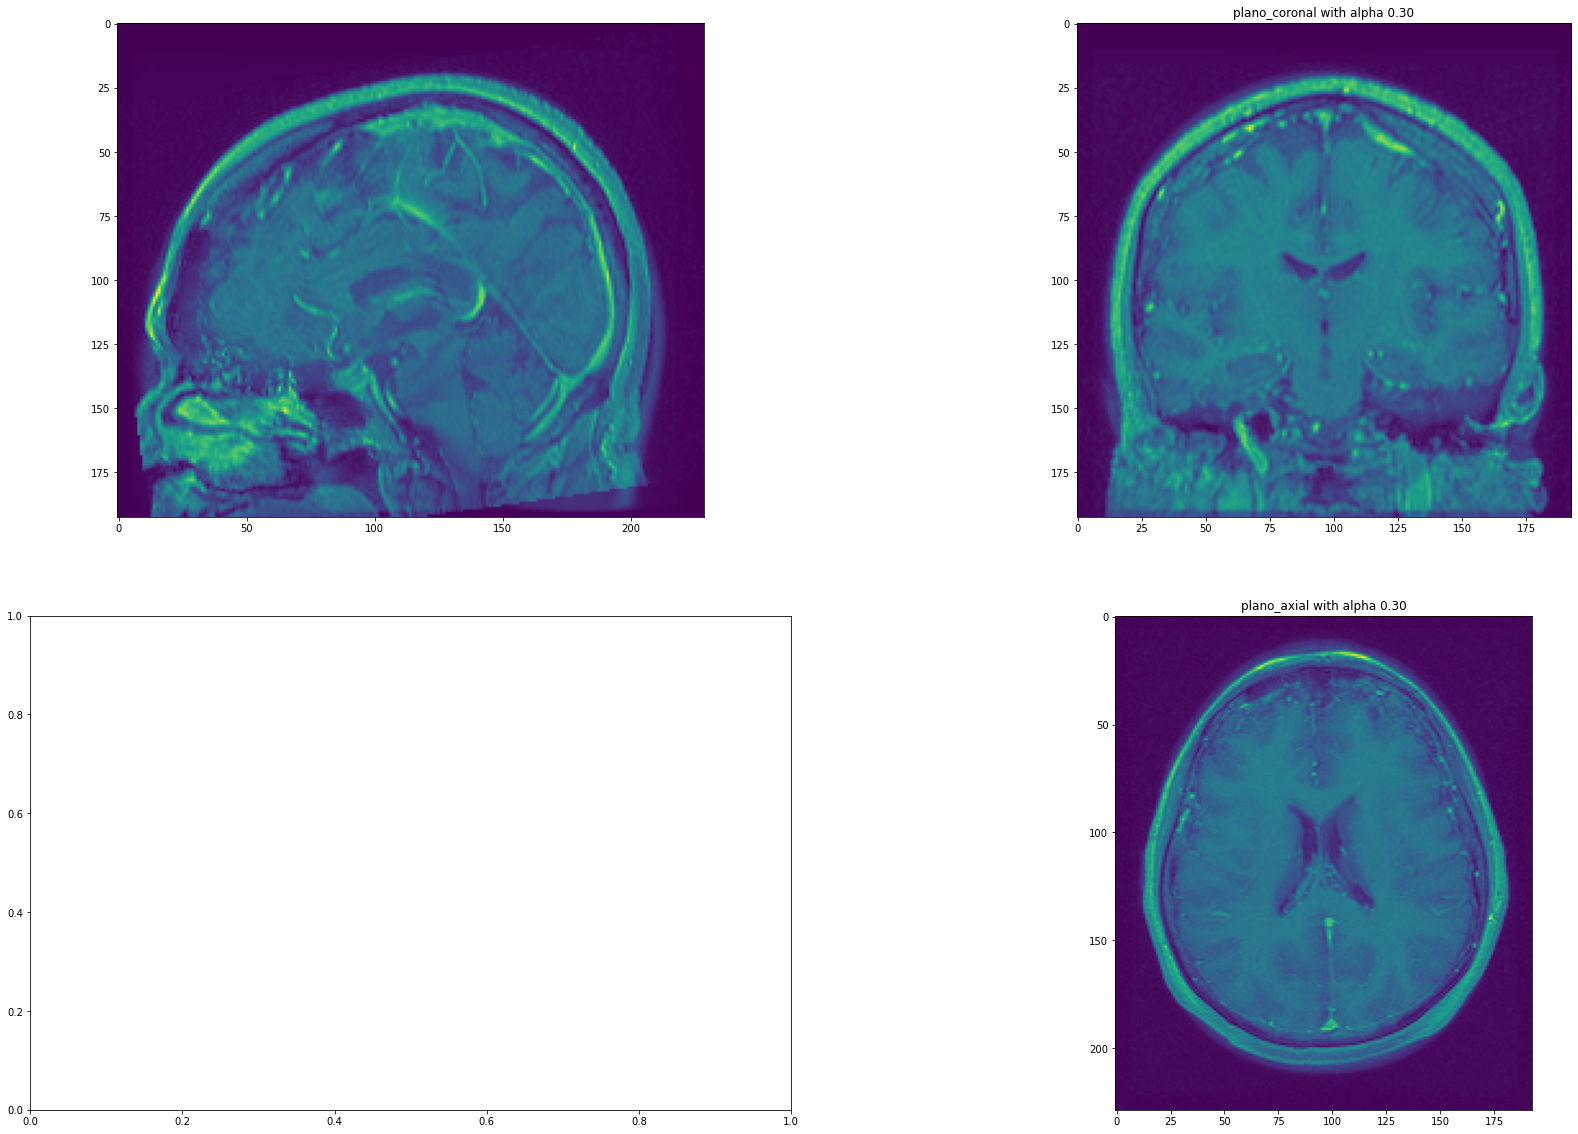

In [29]:
plano_medio_sagital_FIN = TENSOR_FINAL[:, :, 96]
plano_medio_coronal_FIN = TENSOR_FINAL[:, TENSOR_FINAL.shape[1]//2, :]
plano_medio_axial_FIN = TENSOR_FINAL[100, :, :]


plano_medio_sagital_phantom = TENSOR_PHANTOM[:, :, TENSOR_PHANTOM.shape[1]//2]
plano_medio_coronal_phantom = TENSOR_PHANTOM[:, TENSOR_PHANTOM.shape[1]//2, :]
plano_medio_axial_phantom = TENSOR_PHANTOM[TENSOR_PHANTOM.shape[0]//2, :, :]


fig, axs = plt.subplots(2,2, figsize=(30,20))

#apliquem l'algorisme del pintor i representem a la imatge sagital els diferents ossos segons les 'labels'
axs[0,0].imshow(plano_medio_sagital_phantom * 0.60 + plano_medio_sagital_FIN * 0.40)
axs[0,1].imshow(plano_medio_coronal_phantom * 0.60 + plano_medio_coronal_FIN * 0.40)
axs[1,1].imshow(plano_medio_axial_phantom * 0.60 + plano_medio_axial_FIN * 0.40)

axs[0,1].set_title("plano_sagital with alpha 0.30")
axs[0,1].set_title("plano_coronal with alpha 0.30")
axs[1,1].set_title("plano_axial with alpha 0.30");

In [30]:
val_fin = F_PERDUA(TENSOR_TEST, TENSOR_PHANTOM)

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-1i5nllza\opencv\modules\core\src\arithm.cpp:674: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'cv::arithm_op'


In [ ]:
x_opt = val_fin.x

print(f'''
Los mejores parámetros son: 
    1) Traslación respecto al vector ({x_opt[0]}, {x_opt[1]}, {x_opt[2]}).
    2) Rotación axial de {math.degrees(x_opt[3])} grados, eje ({x_opt[4]}, {x_opt[5]}, {x_opt[6]}).
    3) Traslación respecto al vector ({x_opt[7]}, {x_opt[8]}, {x_opt[9]}).
''')

# Visualización del hipotálamo

In [31]:
dcm_rest = dcms4
TENSOR_ATLAS = dcm_rest.pixel_array
TENSOR_ATLAS = np.flip(TENSOR_ATLAS, 0)
TENSOR_ATLAS= np.flip(TENSOR_ATLAS, 1)

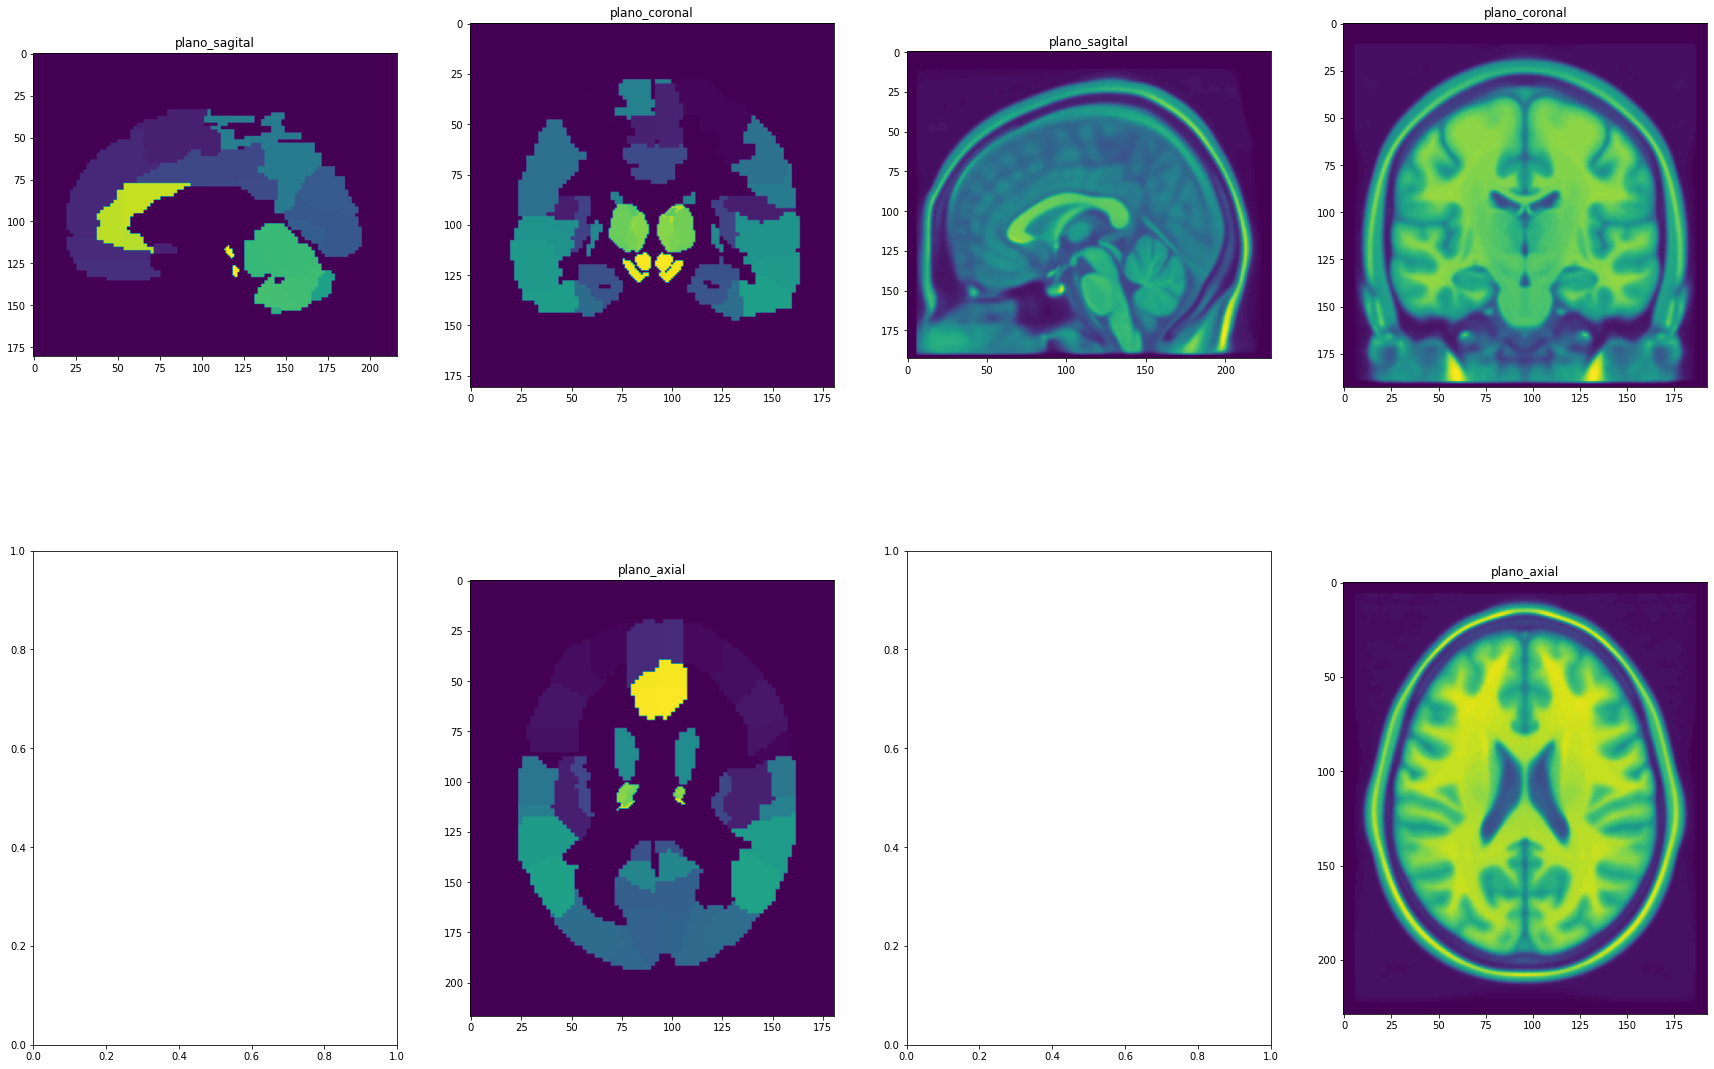

In [32]:
visualiz_sincrono(TENSOR_ATLAS, TENSOR_PHANTOM, False)

In [33]:
resize_data2 = (TENSOR_PHANTOM.shape[0]/TENSOR_ATLAS.shape[0],TENSOR_PHANTOM.shape[1]/TENSOR_ATLAS.shape[1],TENSOR_PHANTOM.shape[2]/TENSOR_ATLAS.shape[2])
resize_data2

(1.0662983425414365, 1.055299539170507, 1.0662983425414365)

In [34]:
TENSOR_ATLAS_RESHAPE = zoom(TENSOR_ATLAS, (resize_data2[0],resize_data2[1],resize_data2[2]))

In [35]:
plano_medio_sagital_atlas_2 = TENSOR_ATLAS_RESHAPE[:, :, TENSOR_ATLAS_RESHAPE.shape[2]//2]
plano_medio_coronal_atlas_2 = TENSOR_ATLAS_RESHAPE[:, TENSOR_ATLAS_RESHAPE.shape[1]//2, :]
plano_medio_axial_atlas_2 = TENSOR_ATLAS_RESHAPE[TENSOR_ATLAS_RESHAPE.shape[0]//2, :, :]

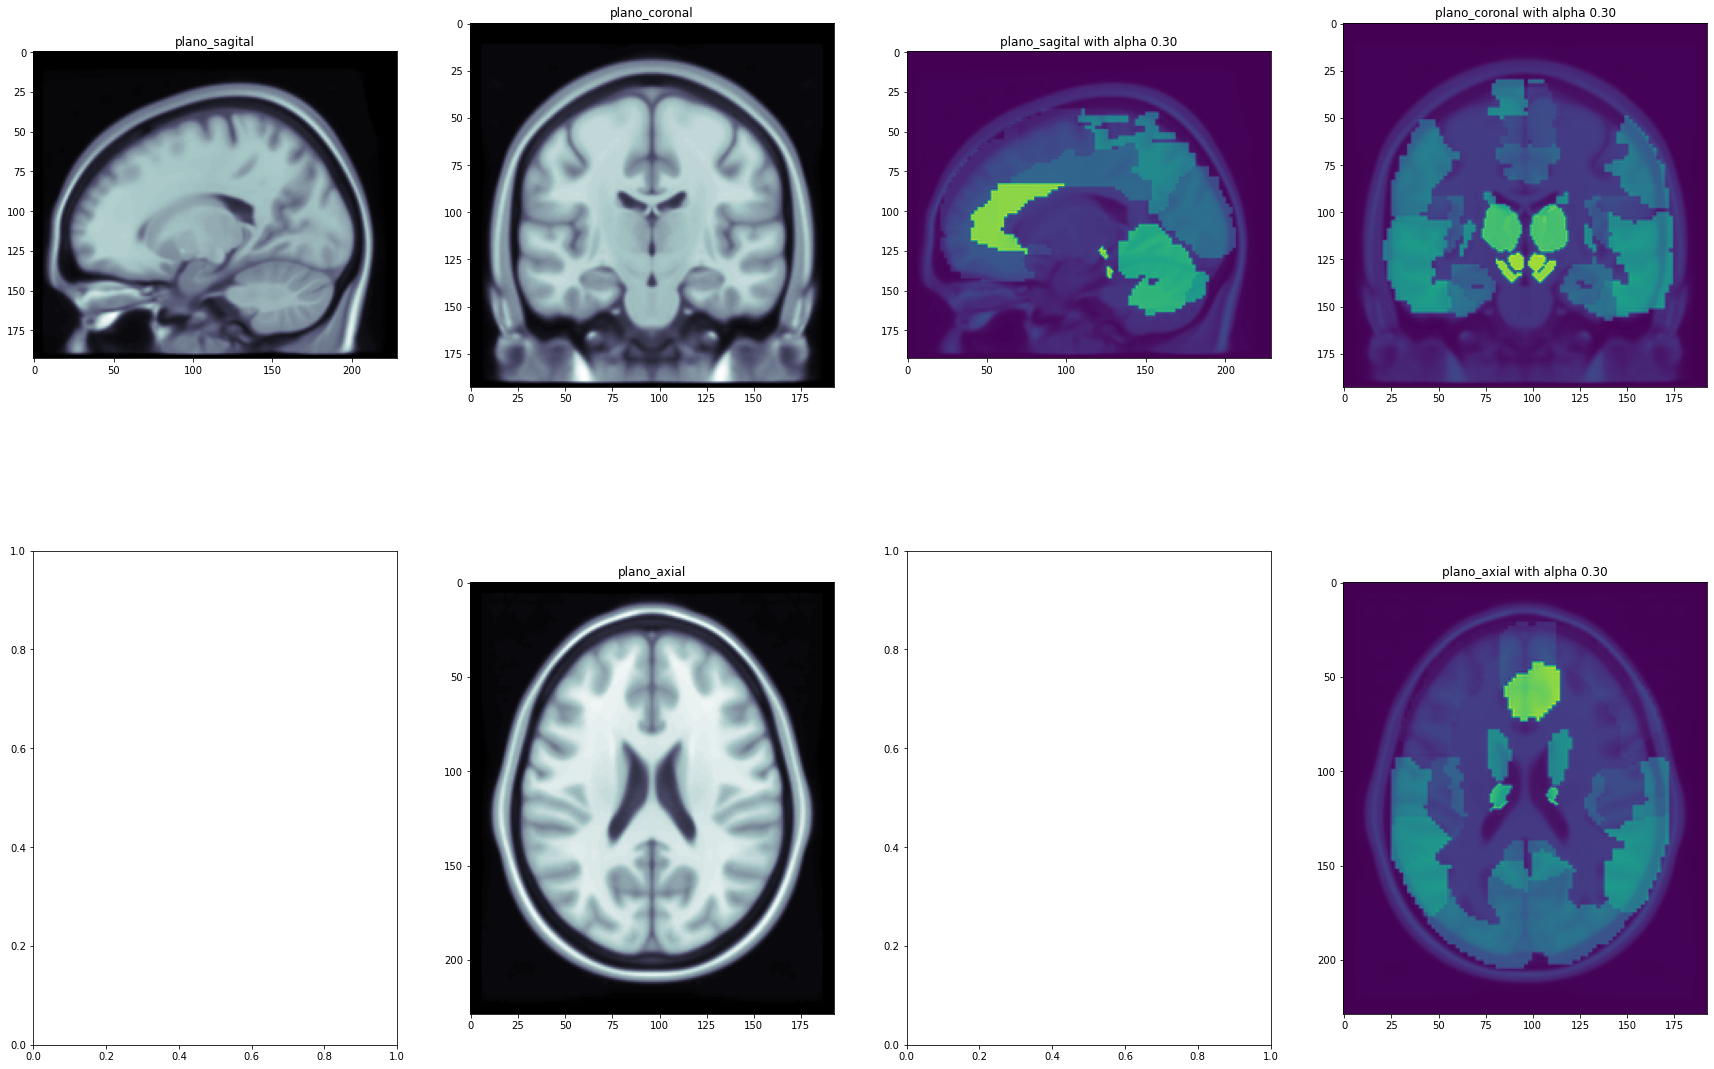

In [36]:
fig, axs = plt.subplots(2,4, figsize=(30,20))
axs[0,0].imshow(plano_medio_sagital_phantom, cmap=plt.cm.get_cmap('bone'))
axs[0,1].imshow(plano_medio_coronal_phantom, cmap=plt.cm.get_cmap('bone'))
axs[1,1].imshow(plano_medio_axial_phantom, cmap=plt.cm.get_cmap('bone'))

#apliquem l'algorisme del pintor i representem a la imatge sagital els diferents ossos segons les 'labels'
axs[0,2].imshow(plano_medio_sagital_phantom * 0.40 + plano_medio_sagital_atlas_2 * 0.60)
axs[0,3].imshow(plano_medio_coronal_phantom * 0.40 + plano_medio_coronal_atlas_2 * 0.60)
axs[1,3].imshow(plano_medio_axial_phantom * 0.40 + plano_medio_axial_atlas_2 * 0.60)

axs[0,0].set_title("plano_sagital")
axs[0,1].set_title("plano_coronal")
axs[1,1].set_title("plano_axial");

axs[0,2].set_title("plano_sagital with alpha 0.30")
axs[0,3].set_title("plano_coronal with alpha 0.30")
axs[1,3].set_title("plano_axial with alpha 0.30");

## Falta localitzar l'hipotàlam i pintar a sobre del pacient anonimitzat

In [37]:
def get_hipothalamus_mask(img_atlas, inf, sup):
    #log.info('Task 1.1: Find binary mask of amygdala')
    mask = np.zeros(img_atlas.shape)
    TENSOR_MASK = ((inf < img_atlas[:,:,:]) & (img_atlas[:,:,:] < sup))

    for z in range(img_atlas.shape[2]):
        for y in range(img_atlas.shape[1]):
            for x in range(img_atlas.shape[0]):
                if (TENSOR_MASK[x,y,z] == True):
                    mask[x,y,z] = 255 

    return mask

In [38]:
hipothalamus_mask = get_hipothalamus_mask(TENSOR_ATLAS_RESHAPE, inf = 121, sup = 150)

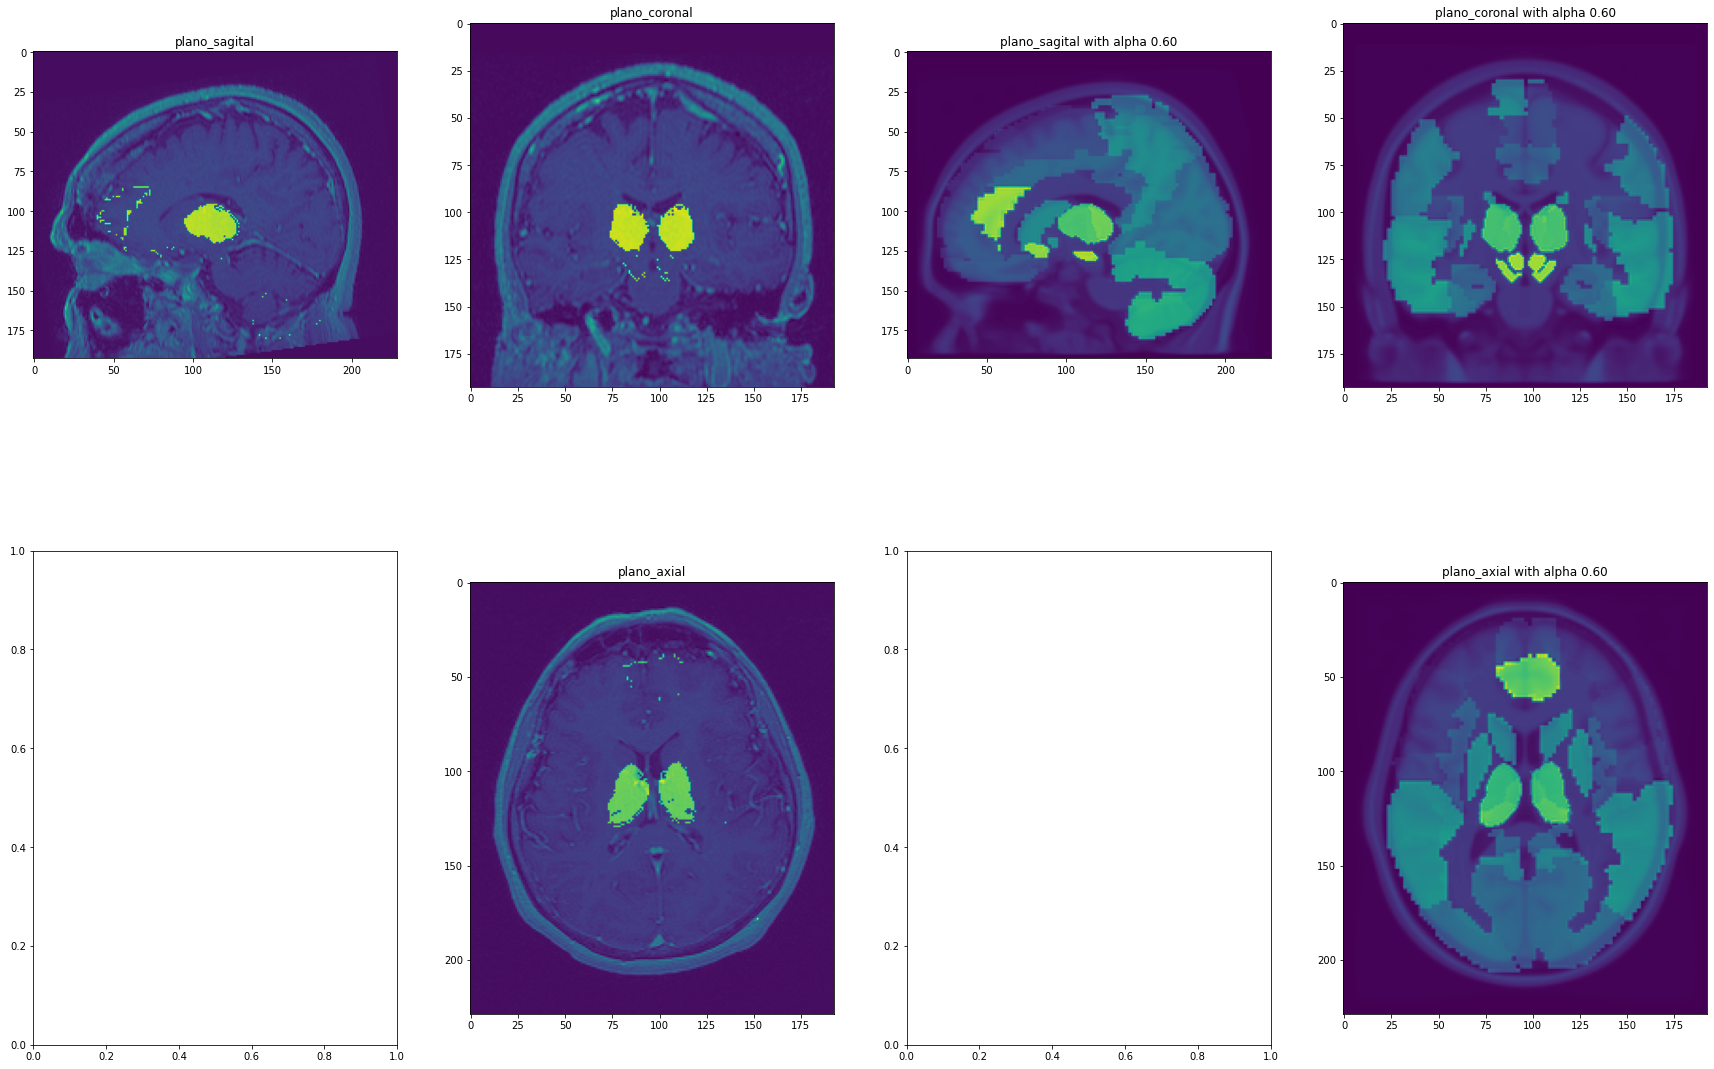

In [39]:
plano_medio_sagital_mask = hipothalamus_mask[:, :, 110]
plano_medio_coronal_mask = hipothalamus_mask[:, hipothalamus_mask.shape[1]//2, :]
plano_medio_axial_mask = hipothalamus_mask[105, :, :]

plano_medio_sagital_FIN = TENSOR_FINAL[:, :, 110]
plano_medio_coronal_FIN = TENSOR_FINAL[:, TENSOR_FINAL.shape[1]//2, :]
plano_medio_axial_FIN = TENSOR_FINAL[105, :, :]

plano_medio_sagital_phantom = TENSOR_PHANTOM[:, :, 110]
plano_medio_coronal_phantom = TENSOR_PHANTOM[:, TENSOR_PHANTOM.shape[1]//2, :]
plano_medio_axial_phantom = TENSOR_PHANTOM[105, :, :]

plano_medio_sagital_atlas_2 = TENSOR_ATLAS_RESHAPE[:, :, 110]
plano_medio_coronal_atlas_2 = TENSOR_ATLAS_RESHAPE[:, TENSOR_ATLAS_RESHAPE.shape[1]//2, :]
plano_medio_axial_atlas_2 = TENSOR_ATLAS_RESHAPE[105, :, :]

fig, axs = plt.subplots(2,4, figsize=(30,20))
axs[0,0].imshow(plano_medio_sagital_FIN * 0.40 + plano_medio_sagital_mask * 0.60)
axs[0,1].imshow(plano_medio_coronal_FIN * 0.40 + plano_medio_coronal_mask * 0.60)
axs[1,1].imshow(plano_medio_axial_FIN * 0.40 + plano_medio_axial_mask * 0.60)

axs[0,2].imshow(plano_medio_sagital_phantom * 0.40 + plano_medio_sagital_atlas_2 * 0.60)
axs[0,3].imshow(plano_medio_coronal_phantom * 0.40 + plano_medio_coronal_atlas_2 * 0.60)
axs[1,3].imshow(plano_medio_axial_phantom * 0.40 + plano_medio_axial_atlas_2 * 0.60)

axs[0,0].set_title("plano_sagital")
axs[0,1].set_title("plano_coronal")
axs[1,1].set_title("plano_axial");

axs[0,2].set_title("plano_sagital with alpha 0.60")
axs[0,3].set_title("plano_coronal with alpha 0.60")
axs[1,3].set_title("plano_axial with alpha 0.60");